In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [2]:
DATASET_PATH = r'C:\Users\student\Downloads\archive\train'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [3]:
# Data Augmentation and Rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=25,
    zoom_range=0.3,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

In [4]:
# Train and Validation Generators
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 1875 images belonging to 10 classes.


In [5]:
val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 464 images belonging to 10 classes.


In [6]:
# Load Pre-trained VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

In [9]:
# Final model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Warm-up training (frozen base)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
    ]
)

D:\kdb\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.1884 - loss: 2.2037 - val_accuracy: 0.5280 - val_loss: 1.5041 - learning_rate: 0.0010
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5092 - loss: 1.4891 - val_accuracy: 0.6638 - val_loss: 1.1449 - learning_rate: 0.0010
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5656 - loss: 1.2179 - val_accuracy: 0.6681 - val_loss: 1.0231 - learning_rate: 0.0010
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6140 - loss: 1.0985 - val_accuracy: 0.6918 - val_loss: 0.9392 - learning_rate: 0.0010
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6619 - loss: 0.9920 - val_accuracy: 0.7091 - val_loss: 0.8574 - learning_rate: 0.0010


In [12]:
# Now fine-tune some deeper VGG16 layers
for layer in base_model.layers[-8:]:  # Unfreeze last 8 conv layers
    layer.trainable = True

In [13]:
# Re-compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# Fine-tune
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
    ]
)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.6927 - loss: 0.8256 - val_accuracy: 0.8125 - val_loss: 0.5688 - learning_rate: 1.0000e-05
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.8086 - loss: 0.5627 - val_accuracy: 0.8233 - val_loss: 0.5386 - learning_rate: 1.0000e-05
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8015 - loss: 0.5359 - val_accuracy: 0.8599 - val_loss: 0.4474 - learning_rate: 1.0000e-05
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.8384 - loss: 0.4622 - val_accuracy: 0.8384 - val_loss: 0.5176 - learning_rate: 1.0000e-05
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8513 - loss: 0.4638
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
59/59 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8514 - loss: 0.4631 - val_accuracy: 0.8621 - val_loss: 0.4578 - learning_rate: 1.0000e-05
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8840 - loss

In [15]:
# Final accuracy
final_train_acc = fine_tune_history.history['accuracy'][-1]
final_val_acc = fine_tune_history.history['val_accuracy'][-1]

print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")

Training Accuracy: 0.9104
Validation Accuracy: 0.9009


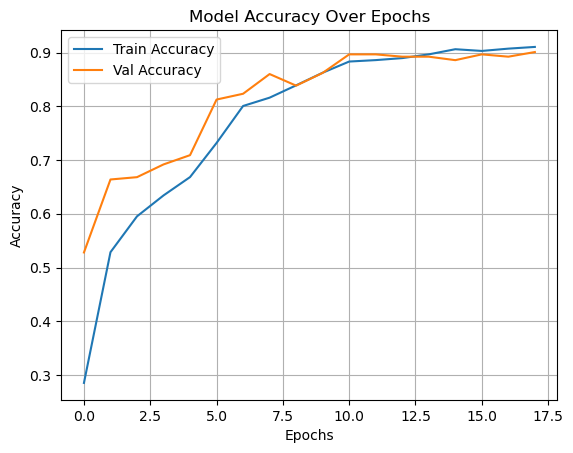

In [16]:
# Plot performance
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()